# Przygotowanie środowisk

In [ ]:
!pip install openml

In [ ]:
!pip install smac

In [ ]:
pip install scikit-optimize

In [ ]:
from ConfigSpace import Configuration, ConfigurationSpace

In [ ]:
import csv

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, KFold
from openml import datasets
from sklearn import set_config
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn import set_config
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

set_config(transform_output = "pandas")

In [ ]:
from smac import HyperparameterOptimizationFacade, Scenario
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from inspect import getblock
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, UniformIntegerHyperparameter

In [ ]:
import openml

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from skopt import BayesSearchCV

In [ ]:
from google.colab import drive
from google.colab import files

# Dane

## Zbiory danych

In [ ]:
datasets = ['credit-g','Phoneme', 'diabetes','kc2']

## Obróbka

In [ ]:
# Define the selector for numeric and categorical features
numeric_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_include=['category', 'object'])

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

col_trans = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_selector),
        ('cat', categorical_transformer, categorical_selector)
    ])

In [ ]:
def preprocess_dataset(dataset_name):
    # Download dataset
    dataset = openml.datasets.get_dataset(dataset_name)
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='array')

    # Create DataFrame
    feature_names = [f"feature_{i}" for i in range(X.shape[1])]
    target_name = "target"
    df = pd.DataFrame(X, columns=feature_names)
    df[target_name] = y

    # Split into features and target
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit and transform the training set
    X_train_transformed = col_trans.fit_transform(X_train)

    # Transform the test set
    X_test_transformed = col_trans.transform(X_test)

    return X_train_transformed, X_test_transformed, y_train, y_test

# Tunowanie

## Hiperparametry

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300,500,1000],
    'learning_rate': [0.01, 0.1,0.25, 0.5, 1],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 10]
}

## Klasyfikator

In [ ]:
gb = GradientBoostingClassifier()

### Randomized Search

In [ ]:
# Define the number of iterations for both RandomSerach and Bayesian Optimization
n_iter=50

In [ ]:
random_optim_results = []
random_results = []
max_scores = []

for dataset_name in datasets:
  X_train, X_test, y_train, y_test = preprocess_dataset(dataset_name)

  # Initialize RandomizedSearchCV
  random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_dist, n_iter=n_iter, cv=10, n_jobs=-1, random_state=42, error_score='raise')
  random_search.fit(X_train, y_train)

  # Fit the model
  random_search.fit(X_train, y_train)

  # Get the best parameters and best score
  best_params = random_search.best_params_
  best_score = random_search.best_score_

  # Use the best parameters to train the final model
  final_model = random_search.best_estimator_

  # Evaluate the model on the test set
  test_accuracy = final_model.score(X_test, y_test)

  # Get the mean test score for all classifiers
  mean_test_scores = random_search.cv_results_['mean_test_score']

  # Append results to the list
  random_optim_results.append({
        'Dataset': dataset_name,
        'Best_Parameters': best_params,
        'Best_Score': best_score,
        'Test_Accuracy': test_accuracy,
  })

  # Get the mean test score for all classifiers
  scores_history = random_search.cv_results_

  # Extract 'params' and 'mean_test_score' from scores_history
  theta = scores_history['params']
  scores = scores_history['mean_test_score']

  # Create a DataFrame for the current dataset
  df_dataset = pd.DataFrame({f'score_{dataset_name}': scores})

  # Append the DataFrame to the results list
  random_results.append(df_dataset)

  # Calculate the maximum score so far over the iterations
  max_score = np.maximum.accumulate(mean_test_scores)
  max_scores.append(max_score)

  # Save the results with unique names
  result_filename = f'results_{dataset_name}_random_search.csv'
  with open(result_filename, 'w') as file:
    file.write(f'Best Parameters: {best_params}\n')
    file.write(f'Best Cross-Validation Accuracy: {best_score}\n')
    file.write(f'Test Set Accuracy: {test_accuracy}\n')
    file.write('\nMean Test Scores for all Classifiers:\n')

    for score in mean_test_scores:
      file.write(f'{score}\n')

  files.download(result_filename)


/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
<ipython-input-17-978857f3a485>:4: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='array')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
<ipython-input-17-978857f3a485>:4: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='array')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
<ipython-input-17-978857f3a485>:4: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='array')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
<ipython-input-17-978857f3a485>:4: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='array')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Create all plots in a separate loop
for (iter, dataset_name) in enumerate(datasets):
  plt.plot(range(1, len(max_scores[iter]) + 1), max_scores[iter], marker='o', linestyle='-', color='b')
  plt.title(f'Maximum Score Over Iterations for {dataset_name} Using Random Search')
  plt.xlabel('Iteration')
  plt.ylabel('Maximum Score So Far')
  plt.grid(True)
  plt.show()

IndexError: ignored

In [ ]:
#Join the results of RandomSearch and the considered theta combinations
random_theta = pd.DataFrame({'theta': theta})
random_df = pd.concat(random_results, axis=1)
random_df=pd.concat([random_theta,random_df], axis=1)

In [ ]:
random_df.to_csv('/content/random_GBC.csv', index=False)
files.download('/content/random_GBC.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Find mean over the four considered sets
random_df['Srednia'] = random_df.iloc[:, 1:5].mean(axis=1)

In [ ]:
#Find the optimal theta that corresponds to the highest mean score
max_av_score_random = random_df['Srednia'].idxmax()
best_param_random = random_df['theta'][max_av_score_random]
best_score_random = random_df['Srednia'][max_av_score_random]

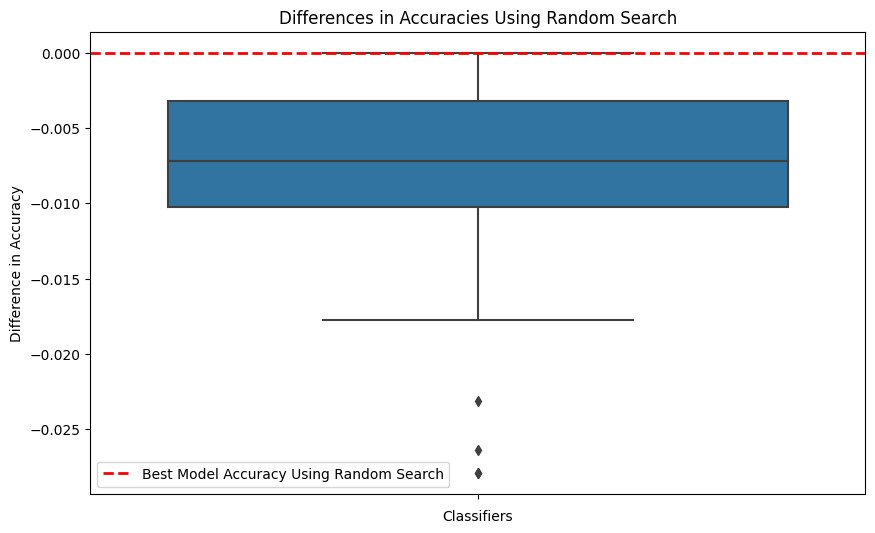

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=random_df['Srednia']-best_score_random)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Best Model Accuracy Using Random Search')
plt.title(f'Differences in Accuracies Using Random Search')
plt.xlabel('Classifiers')
plt.ylabel('Difference in Accuracy')
plt.legend()
plt.show()

## Optymizacja Bayesowska


In [ ]:
# Define the search space for hyperparameters
param_space = {
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
}

In [ ]:
opt = BayesSearchCV(
    gb, # Classifier
    param_space, #Parameter space
    n_iter=n_iter,  # Number of optimization steps
    cv=10,       # Number of cross-validation folds
    random_state=42, #Seed
    n_jobs=-1
)

In [ ]:
bayes_optim_results = []
bayes_results = []

for dataset_name in datasets:
  X_train, X_test, y_train, y_test = preprocess_dataset(dataset_name)
  # Fit the optimizer on the training data
  opt.fit(X_train, y_train)

  # Get the best hyperparameters
  best_params = opt.best_params_
  print("Best Hyperparameters:", best_params)
  best_score = opt.best_score_
  # Evaluate the best model on the test set
  best_model = opt.best_estimator_
  test_accuracy = best_model.score(X_test, y_test)

  # Append results to the list
  bayes_optim_results.append({
      'Dataset': dataset_name,
      'Best_Parameters': best_params,
      'Best_Score': best_score,
      'Test_Accuracy': test_accuracy,
  })

  theta = opt.cv_results_['params']
  scores = opt.cv_results_['mean_test_score']
  bayes_results.append(pd.DataFrame({'theta': theta, 'score': scores}))

  result_filename = f'results_{dataset_name}_bayes_search.csv'
  with open(result_filename, 'w') as file:
    file.write(f'Best Parameters: {best_params}\n')
    file.write(f'Best Cross-Validation Accuracy: {best_score}\n')
    file.write(f'Test Set Accuracy: {test_accuracy}\n')
    file.write('\nMean Test Scores for all Classifiers:\n')

  files.download(result_filename)


In [ ]:
#Concatenate the results of the four optimizations
bayes_results_df = pd.concat(bayes_results, axis=1)

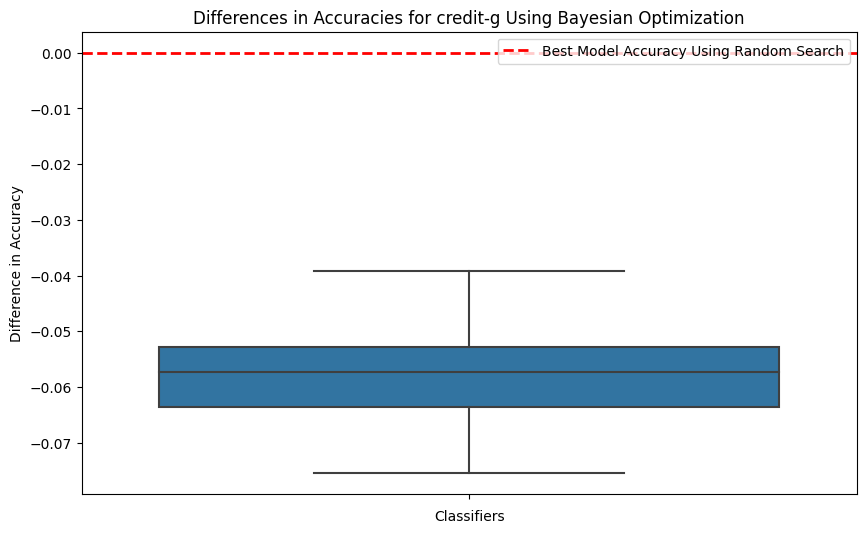

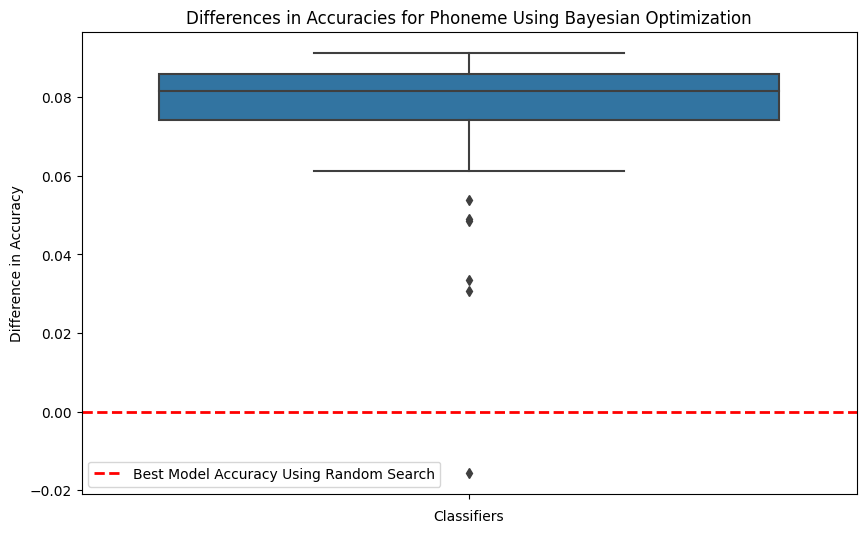

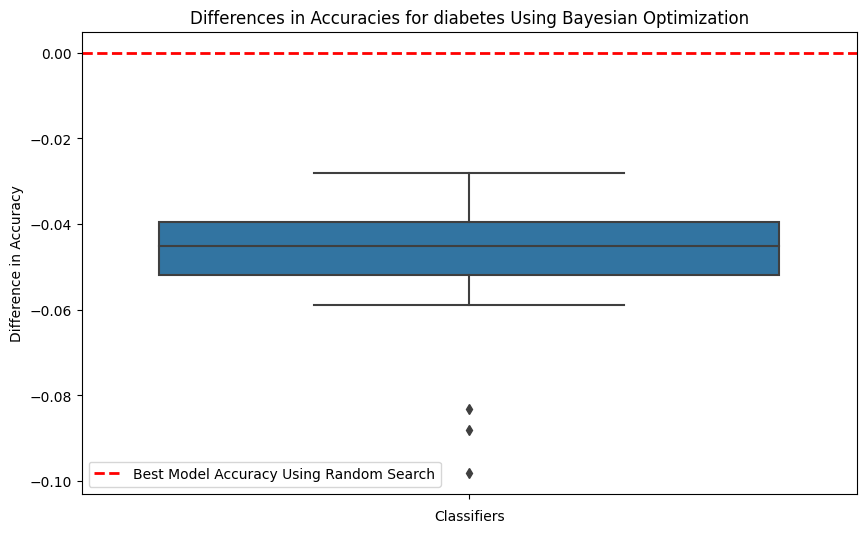

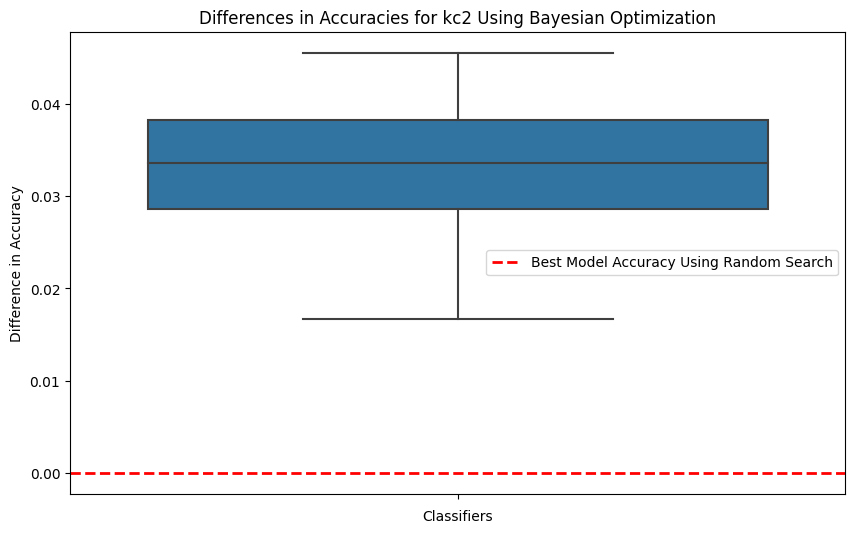

In [ ]:
#Create all four plots in a separate loop
for (iter, dataset_name) in enumerate(datasets):

  acc_diff = bayes_results_df.iloc[:,2*iter+1] - best_score_random
  # Create boxplots
  plt.figure(figsize=(10, 6))
  sns.boxplot(y=acc_diff)
  plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Best Model Accuracy Using Random Search')
  plt.title(f'Differences in Accuracies for {dataset_name} Using Bayesian Optimization')
  plt.xlabel('Classifiers')
  plt.ylabel('Difference in Accuracy')
  plt.legend()
  plt.show()

In [ ]:
bayes_results_df.to_csv('/content/bayes_gbc.csv', index=False)
files.download('/content/bayes_gbc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>